In [ ]:
# Copyright 2024 Stephan Bscheider sbsch@bu.edu
# Copyright 2024 Humzah Durrani hhd8@bu.edu
# Copyright 2024 Alex Tianji Sun tianjis@bu.edu

# EC602 Fall 2024

# Assignment Three

Posted:  October 1, 2024 (finalized Oct 3)

Due:  October 22, 2024 (no class on Oct 15th)


Details
-------

Groups of 1, 2, or 3

Assignment value: one of ten required weekly assignments.


Assignment Description
----------------------

In this assignment, we explore the capabilities of number formats (for integers and real numbers)
with a focus on capabilities, storage and computation.


# Task 1: Exploring Numbers

## Part a: integer capabilities

Generate a Pandas DataFrame with the following columns:

- the number of bytes required in memory for this data type
- the largest possible value storable in this data type (N)
- the number of seconds $T_s$ your computer will take to count from 0 up to this number N
- the number of years $T_s$ represents

You should do this for all signed and unsigned numpy integer types.

Note: to calculate $T_s$, you may need to estimate the value using extrapolation.

In [ ]:
# Answer 1a

# unsigned
for x in [8,16,32,64]:
    print(2**x-1)

255
65535
4294967295
18446744073709551615


In [2]:
2**64 / 1e9 /60/60/24/365

584.942417355072

In [ ]:
import numpy as np
import pandas as pd
import time

data = []
types = ['int8', 'uint8', 'int16', 'uint16', 'int32', 'uint32', 'int64', 'uint64']


count_rate_per_sec = 1e8

for t in types:
    datatype = np.dtype(t)
    Bytes = datatype.itemsize

    if 'u' not in t:
        max_value = (2 ** (Bytes * 8 - 1)) - 1
    else:
        max_value = (2 ** (Bytes * 8)) - 1

    TS = max_value / count_rate_per_sec

    TY = TS / (60 * 60 * 24 * 365)

    data.append([t, Bytes, max_value, TS, TY])

df = pd.DataFrame(data, columns=['Data Type', 'Bytes Required', 'Max Value (N)', 'Time to Count (seconds)', 'Time to Count (years)'])

print(df)


  Data Type  Bytes Required         Max Value (N)  Time to Count (seconds)  \
0      int8               1                   127             1.270000e-06   
1     uint8               1                   255             2.550000e-06   
2     int16               2                 32767             3.276700e-04   
3    uint16               2                 65535             6.553500e-04   
4     int32               4            2147483647             2.147484e+01   
5    uint32               4            4294967295             4.294967e+01   
6     int64               8   9223372036854775807             9.223372e+10   
7    uint64               8  18446744073709551615             1.844674e+11   

   Time to Count (years)  
0           4.027144e-14  
1           8.085997e-14  
2           1.039035e-11  
3           2.078101e-11  
4           6.809626e-07  
5           1.361925e-06  
6           2.924712e+03  
7           5.849424e+03  


## Part b: integer underflow and overflow

Write functions `underflow_int` and `overflow_int` that will
generate integer underflows (creation of a number that is too small) and overflows (creation of a number that is too large) respectively.

The function should return the result in the same type that was passed into it.

In [30]:
# Answer 1b
import numpy as np

def underflow_int(value):
   datatype = np.dtype(type(value))
   bits = value.bit_length()
   max = (1 << (bits - 1)) - 1
   min = -(1 << (bits - 1))
   result = value + 1
   if result > max:
        result = min + (result - max - 1)
   return result
   pass


def overflow_int(value):
   datatype = np.dtype(type(value))
   bits = value.bit_length()
   max = (1 << (bits - 1)) - 1
   min = -(1 << (bits - 1))
   result = value + 1
   if result < min:
        result = max - (min - result - 1)
   return result
   pass

## Part c: float capabilities


Generate a Pandas DataFrame showing the capabilities of each of `numpy` float data types (-16,-32, and 64-bit precision)

For each data type, generate the following columns:

- the number of bytes required in memory for this data type
- the largest possible (non-infinite) value representable in this data type.
- the smallest possible (positive) value representable in this data type.
- the first (smallest positive) integer that is not representable in this data type.
- the approximate number of decimal digits of precision provided by this data type.

  

**to be fixed:**
float is non-linear so when it gets bigger it's more spread out so some numbers are not representable

In [1]:
import numpy as np
import pandas as pd

data = []
types = ['float16', 'float32', 'float64']

for t in types:
    datatype = np.dtype(t)
    Bytes = datatype.itemsize

    max_value = np.finfo(datatype).max
    min_value = np.finfo(datatype).min


    # Find the first unrepresentable integer
    # finfo to find mantissa expoent then add one to 2**exponent
    min_unrepresentable_value = 2**abs(np.finfo(datatype).negep) + 1

    precision = np.finfo(datatype).precision

    data.append([t, Bytes, max_value, min_value, min_unrepresentable_value, precision])

df = pd.DataFrame(data, columns=['Data Type', 'Bytes Required', 'Max Value', 'Min Positive Value', 'First Unrepresentable Integer', 'Precision (Decimal Digits)'])

print(df)

  Data Type  Bytes Required      Max Value  Min Positive Value  \
0   float16               2   6.550400e+04       -6.550400e+04   
1   float32               4   3.402823e+38       -3.402823e+38   
2   float64               8  1.797693e+308      -1.797693e+308   

   First Unrepresentable Integer  Precision (Decimal Digits)  
0                           2049                           3  
1                       16777217                           6  
2               9007199254740993                          15  


# Task 2: communicating / storing numbers

In this task, we will compare the following methods for storing numbers to files:

- `numpy` save/load functions
- `numpy` savetxt/loadtxt functions
- `json` dump/load functions
- `pickle` dump/load functions
- `CSV` file formats pandas.read_csv and pandas.DataFrame.to_csv

## Part a: storage comparison function

Write a function `store_array` that creates a numpy array, and then stores it to
disk, reads it back, and calculates performance of the operation.

The function accepts as input

- the size of the array to create (N)
- the number of dimensions to use (M) (the array will be N x N x ... N) <- M times
- the data type to use (one of numpy: int16,int32,int64,float16,float32,float64)
- a random number generator to employ to populate the array
- the file name to store the result
- the format to use: one of "numpy", "txt", "json", "pickle", and "CSV"


The function should do the following tasks:


- create the random array as specified.
- store the file requested (time this operation)
- read the values back from the file created (time this operation)
- calculate the mean squared error of the result compared to the original.
- delete the file created.


The function returns:
- the created array
- the result read back from file
- a dictionary with the save time, the load time, the file size (in bytes), and the MSE of the result



In [24]:
import numpy as np
import json
import pandas as pd
import os
import random
import time
import pickle

def store_array(N, M, dtype, rng, filename, fileformat):
    A, Aretrieved = None, None
    shape = (N,) * M
    if 'int' in dtype:
        max_val = np.iinfo(dtype).max
        A = np.random.randint(0, max_val, size=shape, dtype=dtype)
    else:
        A = np.random.random(size=shape).astype(dtype)


    shape = A.shape
    df = pd.DataFrame(A)

    start_time = time.time()


    if fileformat == 'numpy':
        np.save(filename, A)
    elif fileformat == 'txt':
        np.savetxt(filename + '.txt', A.flatten())
    elif fileformat == 'json':
        df.to_json(filename + '.json', orient ='records')
    elif fileformat == 'pickle':
        with open(filename + '.plk', 'wb') as f:
            pickle.dump(A, f)
    elif fileformat == 'CSV':
        pd.DataFrame(A.reshape(-1, A.shape[-1])).to_csv(filename + '.csv', index=False, header=False)
    else:
        raise ValueError("Invalid data type, it has to be one of 'numpy','txt','json','pickle' or 'CSV'")

    save_time = time.time() - start_time

#Read the array back from disk
    read_time = time.time()

    if fileformat == 'numpy':
        Aretrieved = np.load(filename + '.npy')
    elif fileformat == 'txt':
        Aretrieved = np.loadtxt(filename + '.txt').reshape(shape)
    elif fileformat == 'json':
        Aretrieved = pd.read_json(filename + '.json')
        #Aretrieved = np.array(json.load(f))
    elif fileformat == 'pickle':
        with open(filename + '.plk', 'rb') as f:
           Aretrieved = pickle.load(f)
    elif fileformat == 'CSV':
        #Aretrieved = np.loadtxt(filename + '.csv', delimiter=',')
        Aretrieved = pd.read_csv(filename + '.csv', header=None).values.reshape(shape)
    # Get the correct filename based on the fileformat
    if fileformat == 'CSV':
        file_size = os.path.getsize(filename + '.csv')
    elif fileformat == 'pickle':
        file_size = os.path.getsize(filename + '.plk')
    elif fileformat == 'numpy':
        file_size = os.path.getsize(filename + '.npy')
    elif fileformat == 'txt':
        file_size = os.path.getsize(filename + '.txt')
    else:
        file_size = os.path.getsize(filename + '.json')

    read_time = time.time() - read_time
    #delete the file
    if fileformat == 'numpy':
        os.remove(filename + '.npy')
    elif fileformat == 'txt':
        os.remove(filename + '.txt')
    elif fileformat == 'json':
        os.remove(filename + '.json')
    elif fileformat == 'pickle':
        os.remove(filename + '.plk')
    elif fileformat == 'CSV':
        os.remove(filename + '.csv')

    MSE = np.mean((A - Aretrieved) ** 2)


    return A, Aretrieved, {"save":save_time,"load":read_time,"size":file_size, "MSE": MSE}


## Part b: testing, results, commentary, visualization

Write test and visualization code that uses `store_array` to compare and contrast the benefits of the various formats.

You can also write code and/or text that describes other pros/cons of the various storage methods.


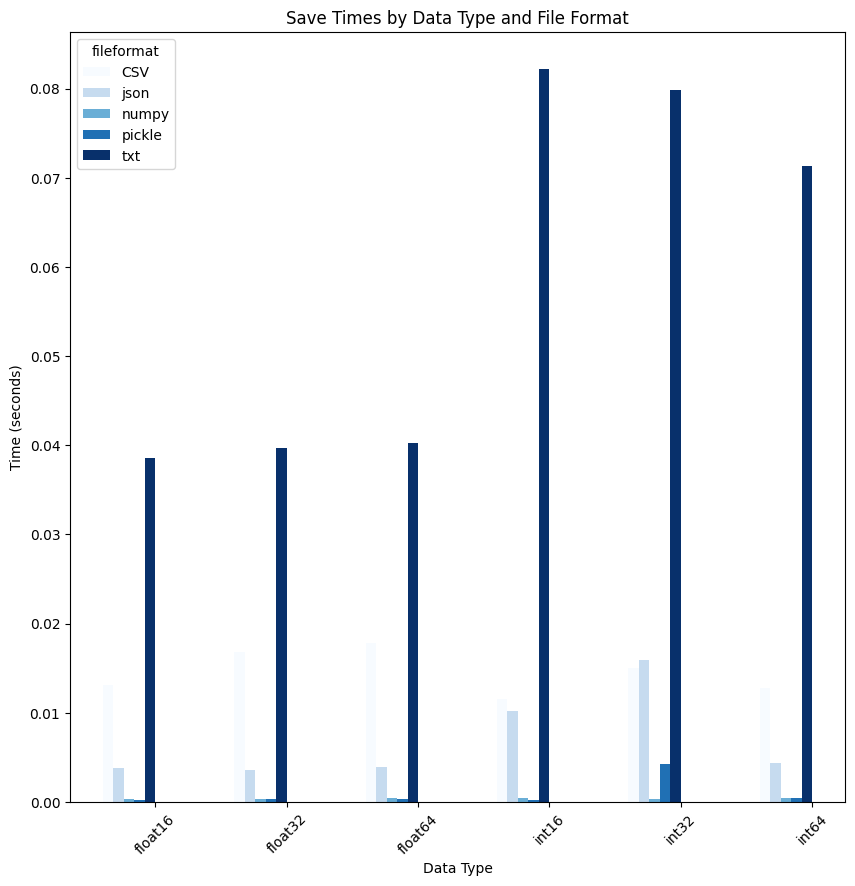

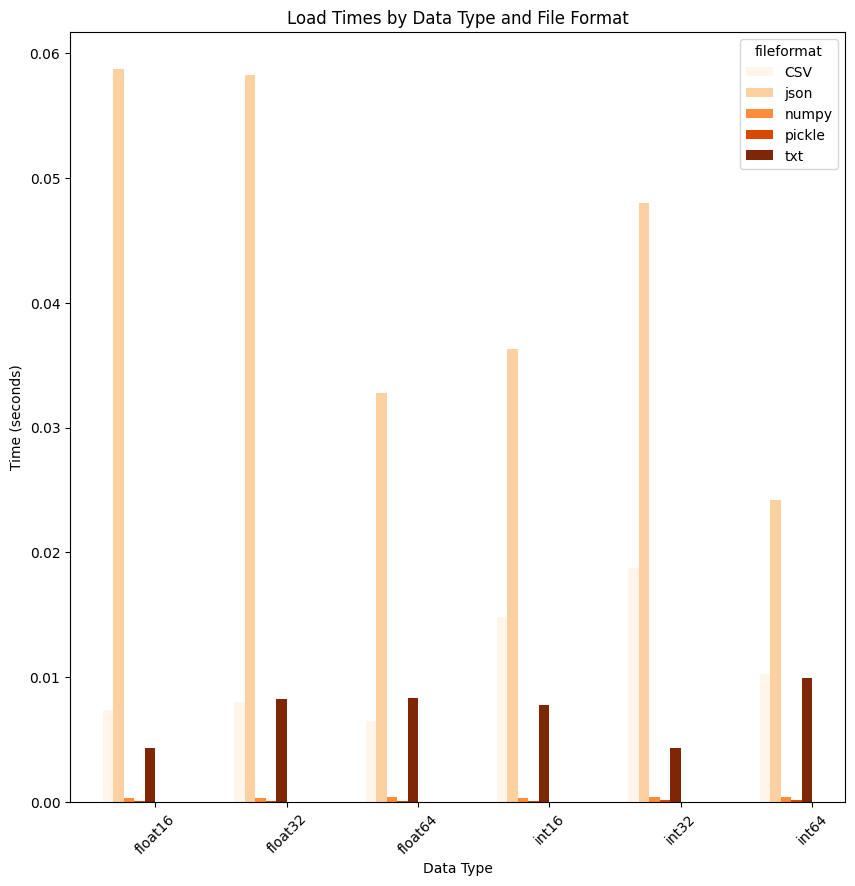

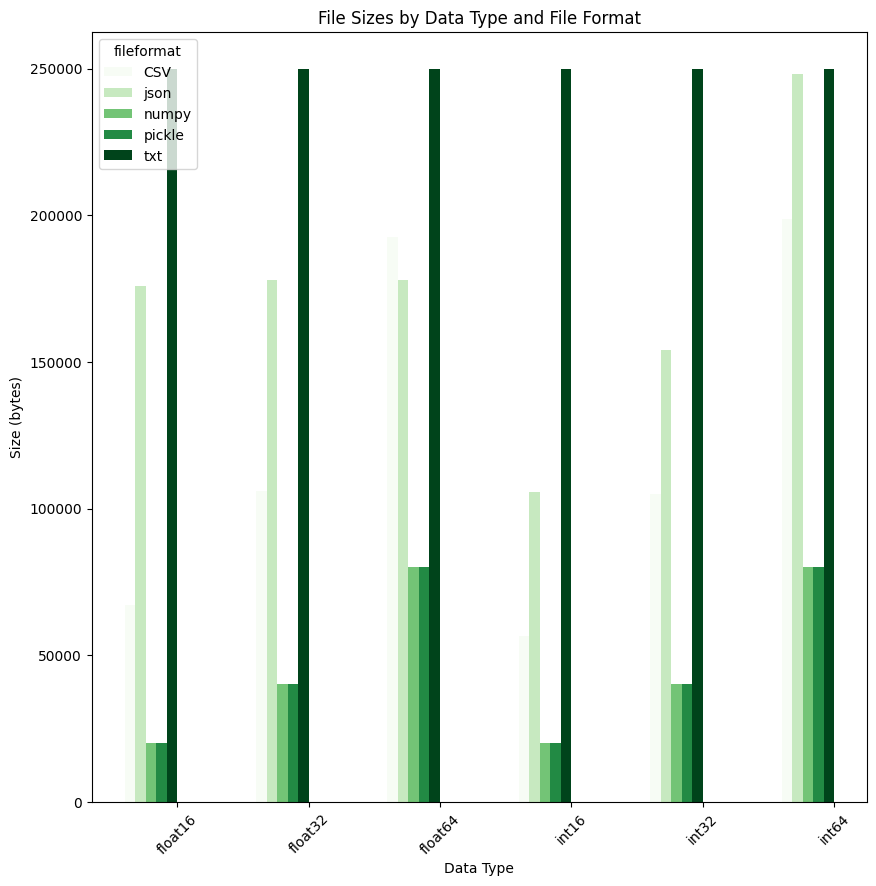

MSE
      dtype fileformat           MSE
0     int16      numpy  0.000000e+00
26  float64        txt  0.000000e+00
25  float64      numpy  0.000000e+00
23  float32     pickle  0.000000e+00
21  float32        txt  0.000000e+00
20  float32      numpy  0.000000e+00
18  float16     pickle  0.000000e+00
16  float16        txt  0.000000e+00
15  float16      numpy  0.000000e+00
28  float64     pickle  0.000000e+00
13    int64     pickle  0.000000e+00
12    int64       json  0.000000e+00
14    int64        CSV  0.000000e+00
10    int64      numpy  0.000000e+00
1     int16        txt  0.000000e+00
2     int16       json  0.000000e+00
3     int16     pickle  0.000000e+00
11    int64        txt  0.000000e+00
5     int32      numpy  0.000000e+00
4     int16        CSV  0.000000e+00
6     int32        txt  0.000000e+00
7     int32       json  0.000000e+00
8     int32     pickle  0.000000e+00
9     int32        CSV  0.000000e+00
29  float64        CSV  1.576547e-33
27  float64       json  8.284304e-

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
fileformats = ["numpy", "txt", "json", "pickle", "CSV"]
N = 100  # Size of the array
M = 2    # Number of dimensions

results = []

for dtype in dtypes:
    for fileformat in fileformats:
        _, _, data = store_array(N, M, dtype, np.random.rand, 'test_array', fileformat)

        results.append([dtype, fileformat, data['save'], data['load'], data['size'], data['MSE']])

df = pd.DataFrame(results, columns=['dtype', 'fileformat', 'save_time', 'load_time', 'file_size', 'MSE'])

fig, ax = plt.subplots(figsize=(10, 10))

save_times = df.pivot(index="dtype", columns="fileformat", values="save_time")
load_times = df.pivot(index="dtype", columns="fileformat", values="load_time")
#save time
save_times.plot(kind='bar', ax=ax, width=0.4, position=1, legend=True, colormap='Blues')
plt.title("Save Times by Data Type and File Format")
plt.ylabel("Time (seconds)")
plt.xlabel("Data Type")
plt.xticks(rotation=45)
plt.show()
#load time
fig, ax = plt.subplots(figsize=(10, 10))
load_times.plot(kind='bar', ax=ax, width=0.4, position=1, legend=True, colormap='Oranges')
plt.title("Load Times by Data Type and File Format")
plt.ylabel("Time (seconds)")
plt.xlabel("Data Type")
plt.xticks(rotation=45)
plt.show()

# File Size
fig, ax = plt.subplots(figsize=(10, 10))
file_sizes = df.pivot(index="dtype", columns="fileformat", values="file_size")
file_sizes.plot(kind='bar', ax=ax, width=0.4, position=1, legend=True, colormap='Greens')
plt.title("File Sizes by Data Type and File Format")
plt.ylabel("Size (bytes)")
plt.xlabel("Data Type")
plt.xticks(rotation=45)
plt.show()
print("MSE")
print(df[['dtype', 'fileformat', 'MSE']].sort_values(by='MSE'))


# Task 3: computational issues

This last part of the assignment is more open ended. Your task is to
design, implement, test, visualize, and summarize a comparison
of computational efficiencies of the four major integer types
(int8, int16, int32, and int64) and the three major float types (float16, float32, and float64)

You can compare between integer types but also integer vs float.

Please also compare between numpy operations and python operations (with standard int and float types).

As a result of your inquiries, you should generate tables and/or graphs
(based on results of your code) that illustrate the differences.

In particular, please focus on:
- what impact does "python code" e.g. for loops, have on your calculations?
- what kinds of array operations would be useful / most common for the data types in use?
- does the size of the array matter (ranging from individual values, to kilo- mega- or giga- sized collections) to average calculation speed per element? If so, develop and test theories
- are there parallelization / speedup tools available that change the results substantially?
- does error handling make a difference (run time checks on overflow, etc)
- can you compare speed benchmarks with other students in the course? What about AMD vs Intel vs Apple performance?


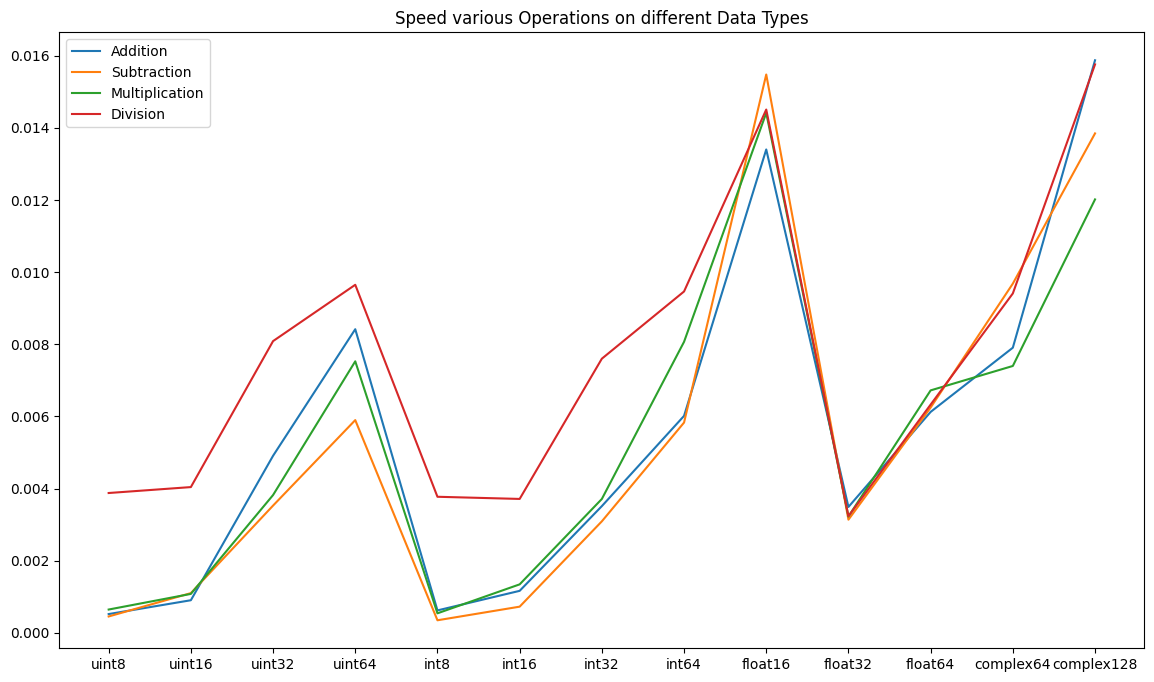

            Addition Subtraction Multiplication  Division  Size (bytes)
uint8       0.000521    0.000454       0.000646  0.003877     4000000.0
uint16      0.000904    0.001102        0.00108  0.004041     8000000.0
uint32      0.004909    0.003528        0.00382  0.008088    16000000.0
uint64      0.008418    0.005898       0.007527  0.009649    32000000.0
int8        0.000622    0.000349       0.000541  0.003772     4000000.0
int16       0.001164    0.000726       0.001344  0.003712     8000000.0
int32       0.003513    0.003091       0.003711    0.0076    16000000.0
int64       0.006015     0.00583       0.008068  0.009464    32000000.0
float16       0.0134    0.015479       0.014413  0.014507     8000000.0
float32      0.00349    0.003138       0.003225  0.003235    16000000.0
float64     0.006125    0.006247       0.006722  0.006327    32000000.0
complex64   0.007905    0.009681       0.007399  0.009409    32000000.0
complex128  0.015873    0.013846       0.012016  0.015758    640

In [ ]:
## This cell compares the speeds of preforming basic math operations of large arrays 2000x2000 of different data types
## In general we found that division is the slowest operation for all int types, and addition is notably slower than subtraction and multiplication for uints.
## for all float types all three operatons are similar in speed, and float 16 is noticably slower than 32 and 64.


import numpy as np
import time
import math
import pandas as pd
import matplotlib.pyplot as plt 



def test_speed(data_type,A,B,o):
    results = []
    
    A = A.astype(data_type)
    B = B.astype(data_type)

    if o == "Addition":
        start_time = time.time()
        result = A + B
        end_time = time.time()
    elif o == "Subtraction":    
        start_time = time.time()
        result = A - B
        end_time = time.time()
    elif o == "Multiplication":   
        start_time = time.time()
        result = A * B
        end_time = time.time()
    elif o == "Division":
        start_time = time.time()
        result = A / B
        end_time = time.time()
    else:
        pass
    
    elapsed_time = end_time - start_time
    results.append(data_type)
    results.append(elapsed_time)
    

    #print(results)
    return results[1]
    
typelist = ['uint8', 'uint16', 'uint32', 'uint64',
            'int8', 'int16', 'int32', 'int64',
            'float16', 'float32', 'float64',
            'complex64', 'complex128']

opslist = ["Addition", "Subtraction", "Multiplication", "Division"]
# Size of arrays
n = 2000
A = np.random.randint(1, 100, (n,n))
B = np.random.randint(1, 100, (n,n))

df = pd.DataFrame(columns=opslist,index=typelist)

for o in opslist:
    #print(f"Operation: {o}")
    
    for t in typelist:
        
        df.iloc[typelist.index(t),opslist.index(o)]=test_speed(t,A,B,o)

typesize = pd.Series(index = typelist)
for t in typelist:
    size = n * n * np.dtype(t).itemsize
    typesize.loc[t] = size
    #print(f"Number of bytes for {t}: {size}")

plt.figure(figsize=(14,8))
plt.plot(df)
plt.title("Speed various Operations on different Data Types")
plt.legend(opslist)
plt.show()

df['Size (bytes)'] = typesize
print(df)  



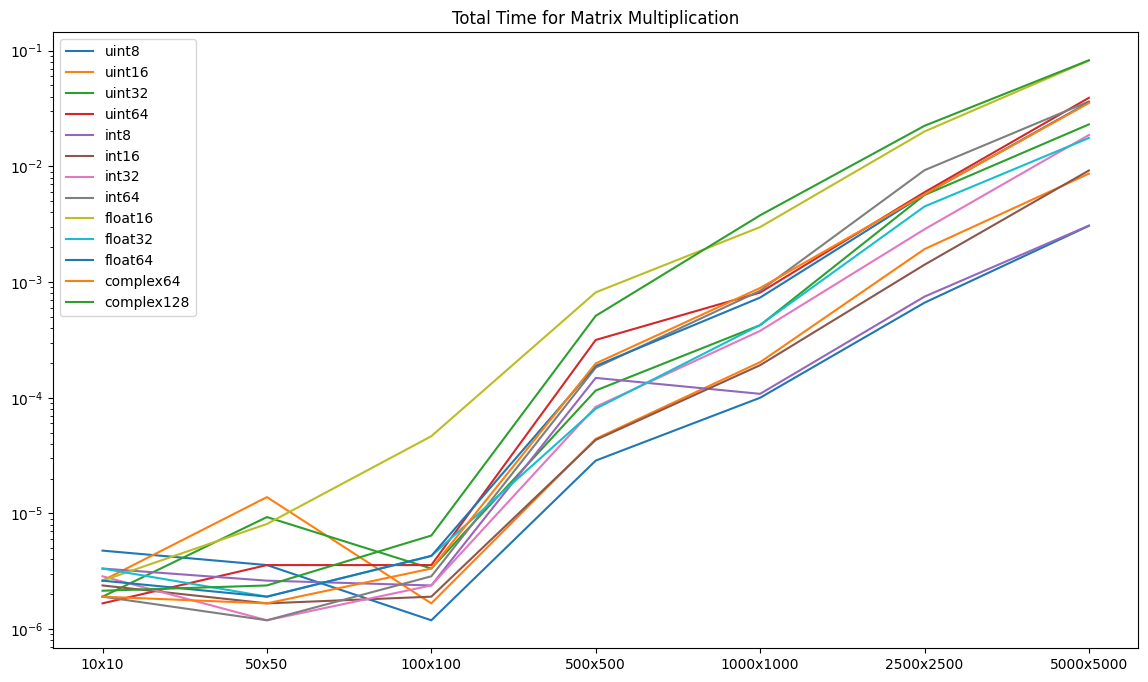

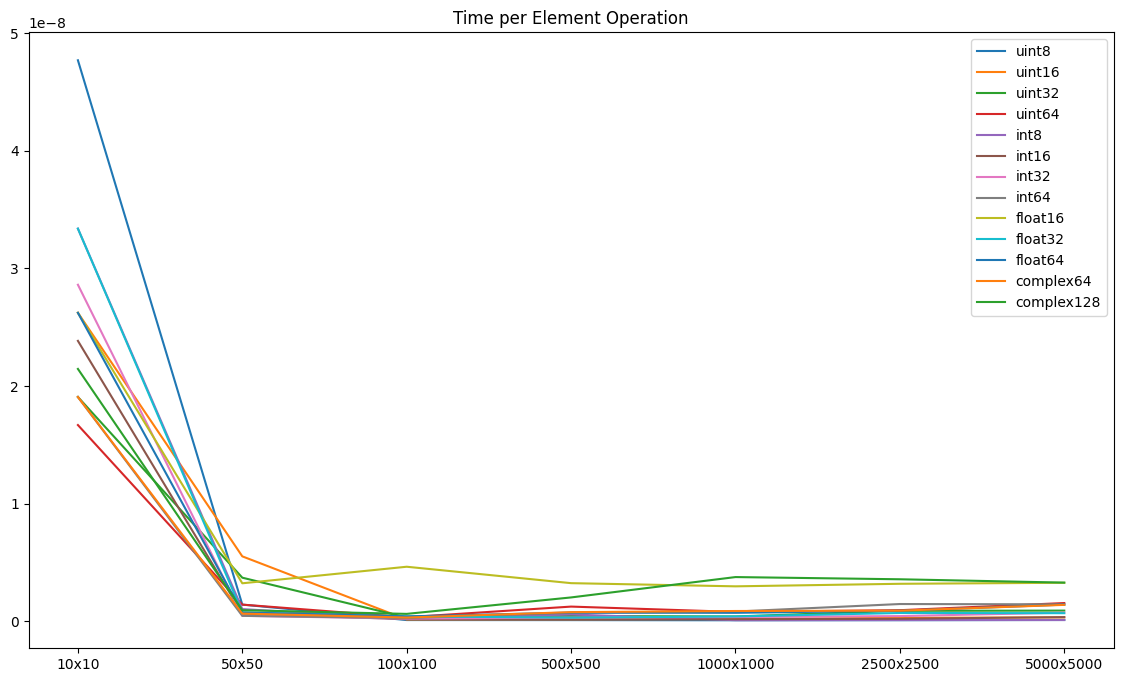

In [ ]:
## This cell computes a matrix multiplication between two randomly generated matricies  of varying different sizes, from 10x10 to 5000x5000,
## and compares both the total elapsed time between sizes of matricies and speed of operation per matrix element in two plots.
## Found that time per operation decreases as the size of the matrix increases and hits a theshold after about a 100x100 matrix

import numpy as np
import time
import math
import pandas as pd
import matplotlib.pyplot as plt 

def test_speed(data_type,n):
    results = []

    A = np.random.randint(1, 100, (n,n)).astype(data_type)
    B = np.random.randint(1, 100, (n,n)).astype(data_type)
    start_time = time.time()
    matrixOp = A * B
    end_time = time.time()
    size = n*n
    
    elapsed_time = end_time - start_time
    results.append(data_type)
    results.append(elapsed_time)
    results.append(size) 
   
    return results
    
typelist = ['uint8', 'uint16', 'uint32', 'uint64',
            'int8', 'int16', 'int32', 'int64',
            'float16', 'float32', 'float64',
            'complex64', 'complex128']

nlist = [10,50,100,500,1000,2500,5000]
opslist = ["10x10","50x50", "100x100","500x500", "1000x1000","2500x2500", "5000x5000"]
# Size of arrays


dfperop = pd.DataFrame(columns=typelist,index=opslist)
dftot = pd.DataFrame(columns=typelist,index=opslist)

for n in nlist:
    #print(f"Operation: {o}")
    timeperoplist = []
    timelist = []
    for t in typelist:
        temp = test_speed(t,n)
        timelist.append(temp[1])
        #print(timelist)
        timeperoplist.append(temp[1]/temp[2])
        dfperop.iloc[nlist.index(n),typelist.index(t)]=timeperoplist[typelist.index(t)]
        dftot.iloc[nlist.index(n),typelist.index(t)]=timelist[typelist.index(t)]
        
plt.figure(0,figsize=(14,8))
plt.plot(dftot)
plt.title('Total Time for Matrix Multiplication')
plt.legend(typelist)
plt.yscale('log')
plt.show()

plt.figure(1,figsize=(14,8))
plt.plot(dfperop)
plt.title('Time per Element Operation')
plt.legend(typelist)
#plt.yscale('log')
plt.show()




In [ ]:
## In this cell we experimented with multiprocessing to speed up the matrix operations that we have been preforming in the previous cells. The first big takeaway is that the running these matrix multiplication across multiple
## processes actually is not speeding up the total time of computation. We found that to square 4 unique matrices of size 500x500, the single process was about 200 times faster than the multi process, but for matrices of size
## 10000x10000, the multi process was about 2.5 times faster than the single process. This trend makes me hopeful that as the matrix size increases the multiprocess will actually make the computation faster per operation than a 
## single process. From reading online it seems that numpy is extremely optimized for these computations in a single thread so it wildly outpreforms the multi process for smaller matrix sizes.

import numpy as np
import time
import math
import pandas as pd
import matplotlib.pyplot as plt 
from multiprocessing import Pool


def test_speed(matrices):

    start_time = time.time()
    for A in matrices:
        matrixOp = A * A
    end_time = time.time()
    
    elapsed_time = end_time - start_time
    return elapsed_time

def matrix_multiply(A):
    return A * A

def test_speed_mp(matrices):

    start_time = time.time()
    with Pool(4) as pool:
        matrixOp = pool.map(matrix_multiply, matrices)
    end_time = time.time()

    elapsed_time = end_time - start_time
    
    return elapsed_time


nBIG = 10000
nSmall = 500
# Size of arrays

matricesBIG= []
matricesSMALL = []
for i in range(4):  # Create 4 big matrices
    matricesBIG.append(np.random.randint(1, 100, (nBIG,nBIG)).astype('float16')) #Noticed float 16 is slowest so using that to try to see a difference

for i in range(4):  # Create 4 small matrices
    matricesSMALL.append(np.random.randint(1, 100, (nSmall,nSmall)).astype('float16')) #Noticed float 16 is slowest so using that to try to see a difference

smallsingletime = test_speed(matricesSMALL)
smallmultitime = test_speed_mp(matricesSMALL)
bigsingletime = test_speed(matricesBIG)
bigmultitime = test_speed_mp(matricesBIG)


print(f"Big Matrix single: {bigsingletime}")
print(f"Big Matrix multi: {bigmultitime}")
print(f"Big time ratio {bigmultitime/bigsingletime}")

print(f"Small Matrix single: {smallsingletime}")
print(f"Small Matrix multi: {smallmultitime}")
print(f"Small time ratio {smallmultitime/smallsingletime}")




Big Matrix single: 1.366283893585205
Big Matrix multi: 3.3570804595947266
Big time ratio 2.4570885123922235
Small Matrix single: 0.002789735794067383
Small Matrix multi: 0.6313149929046631
Small time ratio 226.29920519613708
